In [3]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
class MRI(Dataset):
    def __init__(self,no_path,yes_path):

        self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = \
        None, None, None, None, None, None

        self.mode = 'train'
        self.images, self.labels = None, None

        no_tumor = list()
        ye_tumor = list()
        al_images = list()

        for p in glob.iglob(no_path + "//*.*"):
          img = cv2.imread(p)
          img = cv2.resize(img,(128,128))
          no_tumor.append(img)

        for p in glob.iglob(yes_path + "//*.*"):
          img = cv2.imread(p)
          img = cv2.resize(img,(128,128))
          ye_tumor.append(img)

        cat_images = np.concatenate((ye_tumor, no_tumor), axis=0)

        for img in cat_images:
          tmp = ToTensor()(img)
          al_images.append(tmp)

        ye_label = np.ones(len(ye_tumor), dtype=np.uint8)
        no_label = np.zeros(len(no_tumor), dtype=np.uint8)

        self.images = al_images
        self.labels = np.concatenate((ye_label, no_label))

    def split_data(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.05, random_state=42)
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.X_train, self.y_train, test_size=0.15, random_state=42)

    def plot_img(self,index):
      plt.figure(figsize=(5, 5))
      plt.axis("off")
      if self.labels[index]:
        plt.title('Tumor')
      else:
        plt.title('Health')
      plt.imshow(np.array(self.images[index]).transpose(1,2,0))

    def __len__(self):
        if self.mode == 'train':
            return len(self.X_train)
        elif self.mode == 'val':
            return len(self.X_val)
        elif self.mode == 'test':
            return len(self.X_test)

    def __getitem__(self, index):
        if self.mode== 'train':
            return {'image': self.X_train[index], 'label': self.y_train[index]}
        elif self.mode== 'val':
            return {'image': self.X_val[index], 'label': self.y_val[index]}
        elif self.mode== 'test':
            return {'image': self.X_test[index], 'label': self.y_test[index]}

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        return x

In [65]:
no_tumor_path = r'./data/path_directory_no_tumor'
yes_tumor_path = r'./data/path_directory_yes_tumor'

In [66]:
mri_data = MRI(no_tumor_path,yes_tumor_path)

In [67]:
mri_data.split_data()

In [87]:
len(mri_data)

204

In [88]:
random_num = np.random.randint(1,len(mri_data),1)[0]
random_num

6

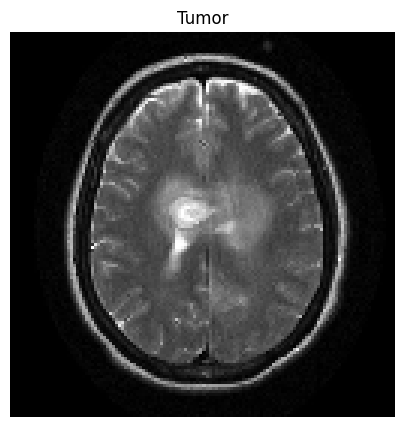

In [89]:
mri_data.plot_img(random_num)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


In [116]:
dataloader = DataLoader(mri_data, batch_size=8, shuffle=True)

In [117]:
model = CNN().to(device)

In [118]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for dl in dataloader:
        image = dl['image'].to(device)
        label = dl['label'].to(device)
        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [94]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [119]:
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )
accuracy_score(y_true, threshold(outputs))

0.46153846153846156

In [110]:
model1 = CNN().to(device)

In [111]:
train_dataloader = DataLoader(mri_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_data, batch_size=32, shuffle=False)

In [112]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [113]:
epoch_train_loss = []
epoch_val_loss = []

In [114]:
for epoch in range(1,300):
    train_losses = []
    model1.train()
    mri_data.mode = 'train'
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error((y_hat.squeeze()).to(torch.float), (label).to(torch.float)))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    epoch_train_loss.append(np.mean(train_losses))

    val_losses = []
    model1.eval()
    mri_data.mode = 'val'
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error((y_hat.squeeze()).to(torch.float16), (label).to(torch.float16)))
            val_losses.append(loss.item())
    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.249739	Val Loss: 0.816895
Train Epoch: 20	Train Loss: 0.251659	Val Loss: 0.817383
Train Epoch: 30	Train Loss: 0.223374	Val Loss: 0.830566
Train Epoch: 40	Train Loss: 0.212520	Val Loss: 0.833984
Train Epoch: 50	Train Loss: 0.195586	Val Loss: 0.836914
Train Epoch: 60	Train Loss: 0.192622	Val Loss: 0.860352
Train Epoch: 70	Train Loss: 0.202883	Val Loss: 0.873047
Train Epoch: 80	Train Loss: 0.174223	Val Loss: 0.904785
Train Epoch: 90	Train Loss: 0.157069	Val Loss: 0.950684
Train Epoch: 100	Train Loss: 0.149390	Val Loss: 0.944824
Train Epoch: 110	Train Loss: 0.136227	Val Loss: 1.028320
Train Epoch: 120	Train Loss: 0.134751	Val Loss: 1.060547
Train Epoch: 130	Train Loss: 0.123886	Val Loss: 1.079102
Train Epoch: 140	Train Loss: 0.115355	Val Loss: 1.144531
Train Epoch: 150	Train Loss: 0.096728	Val Loss: 1.135742
Train Epoch: 160	Train Loss: 0.093996	Val Loss: 1.138672
Train Epoch: 170	Train Loss: 0.086424	Val Loss: 8.265625
Train Epoch: 180	Train Loss: 0.074054	Va

Text(0, 0.5, 'Loss')

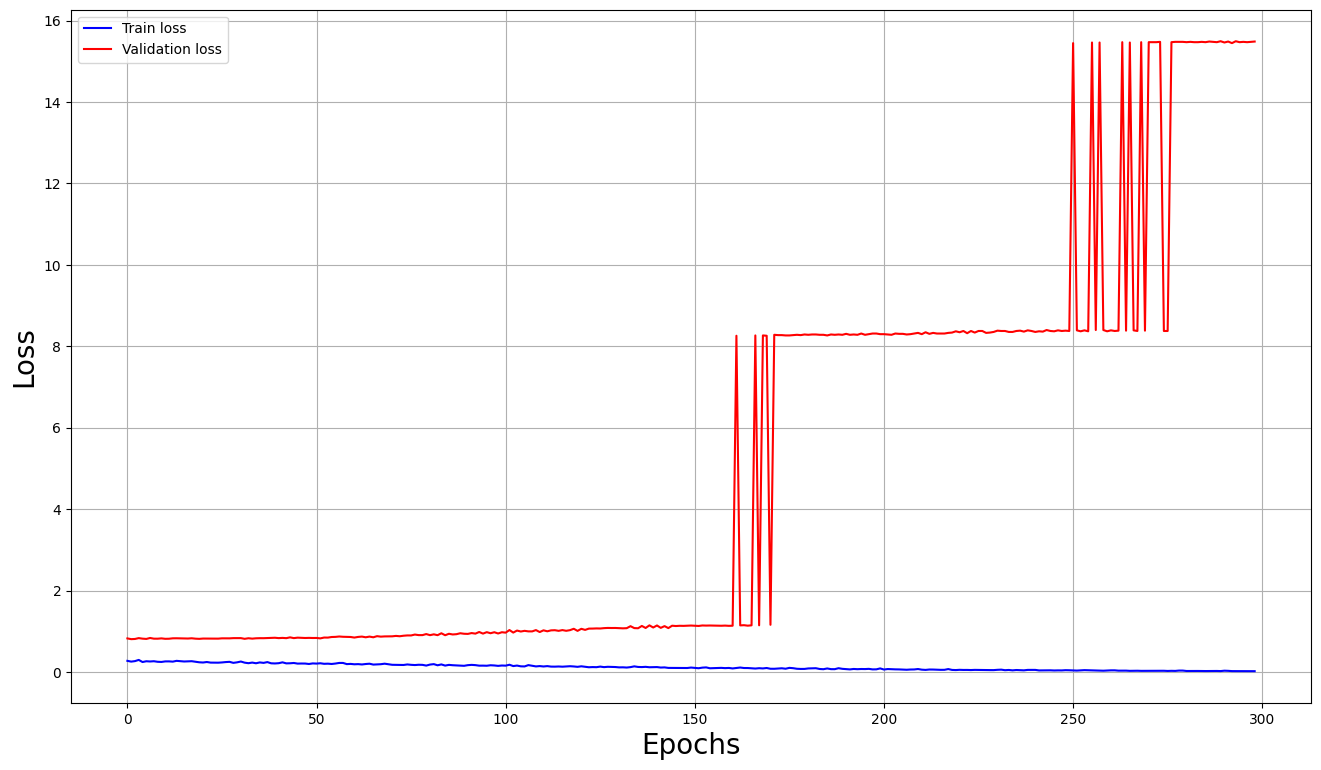

In [115]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)